In [3]:
import pandas as pd
import numpy as np
import random
data=pd.read_csv("FAOLEX.csv")
print(data.keys())
np.random.seed(69)
random.seed(69)

Index(['Record Id', 'Record URL', 'Document URL', 'Title', 'Original title',
       'Date of original text', 'Last amended date', 'Available website',
       'Language of document', 'Country/Territory', 'Regional organizations',
       'Territorial subdivision', 'Type of text', 'Repealed', 'Abstract',
       'Primary subjects', 'Domain', 'Keywords'],
      dtype='object')


In [44]:
import nltk
keywords_nofilter=list(data["Keywords"])
country_nofilter=list(data["Country/Territory"])
i=0
# Split alle keywords op i en liste og ændrer nan til at være en str med Nan
for words in keywords_nofilter:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="NaN"
    if type(country_nofilter[i])!=str:
        country_nofilter[i]="NaN"
    keywords_nofilter[i]=words.split(";")
    i+=1




In [45]:
#Remove Nan from keywords and countries
keywords = []
country = []

for i in range(len(keywords_nofilter)):
    if keywords_nofilter[i] != ["NaN"] and country_nofilter[i]!="NaN":
        keywords.append(keywords_nofilter[i])
        country.append(country_nofilter[i])




In [6]:
# Ignore
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
import numpy as np
stemmer = SnowballStemmer("english")
stemmed_words=[]
for i in range(len(keywords)):
    stemmed_words.append([stemmer.stem(word) for word in keywords[i]])



In [7]:
print(keywords[15])
print(stemmed_words[15])


['marine fisheries', ' traditional rights/customary rights', ' fishing authorization', ' allocation/quota', ' fishery management and conservation']
['marine fisheri', ' traditional rights/customary right', ' fishing author', ' allocation/quota', ' fishery management and conserv']


# Top2vec topic model

In [8]:
# Make a top2vec topic model
from top2vec import Top2Vec
i=0
for word in keywords:
    keywords[i]="".join(word)
    i+=1
model = Top2Vec(keywords,embedding_model="doc2vec")


/Users/gustavnielsen/Documents/Fagprojekt-1/top2vec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-06-06 17:59:02,735 - top2vec - INFO - Pre-processing documents for training
2023-06-06 17:59:09,299 - top2vec - INFO - Creating joint document/word embedding
2023-06-06 18:02:43,910 - top2vec - INFO - Creating lower dimension embedding of documents
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-06-06 18:04:14,722 - top2vec - INFO - Finding dense areas of documents
2023-06-06 18:04:20,650 - top2vec - INFO - Finding topics


In [9]:
topic_sizes, topic_nums = model.get_topic_sizes()
topic_sizes

array([1294, 1240, 1173, ...,   21,   21,   19])

In [10]:
model.get_num_topics()

1155

In [11]:
topic_words,word_scores,topic_nums = model.get_topics(5)

In [577]:
#print(topic_words)

In [268]:
# Find documents most similar to a specific topic
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=110, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 115013, Score: 0.9707304239273071
-----------
fishery management and conservation international agreement-text biodiversity
-----------

Document: 118371, Score: 0.9685155153274536
-----------
international agreement-text international trade animal health quarantine
-----------

Document: 89199, Score: 0.9650817513465881
-----------
international agreement-text energy conservation/energy production international agreement-text
-----------

Document: 17535, Score: 0.9650720357894897
-----------
international agreement-text animal health
-----------

Document: 46065, Score: 0.9645030498504639
-----------
animal health international agreement-text international trade
-----------

Document: 129251, Score: 0.9629270434379578
-----------
international agreement-text agricultural development
-----------

Document: 118362, Score: 0.9607734680175781
-----------
international agreement-text
-----------

Document: 17524, Score: 0.9600027203559875
-----------
international agreement-text

In [269]:
# Check documents
data.iloc[370]

Record Id                                                     LEX-FAOC001446
Record URL                 http://www.fao.org/faolex/results/details/en/c...
Document URL                     https://faolex.fao.org/docs/pdf/ivc1446.pdf
Title                      Décret nº 66-399 portant création d'un Comité ...
Original title                                                           NaN
Date of original text                                             13-09-1966
Last amended date                                                        NaN
Available website                                                        NaN
Language of document                                                  French
Country/Territory                                              Côte d'Ivoire
Regional organizations                                                   NaN
Territorial subdivision                                                  NaN
Type of text                                                      Regulation

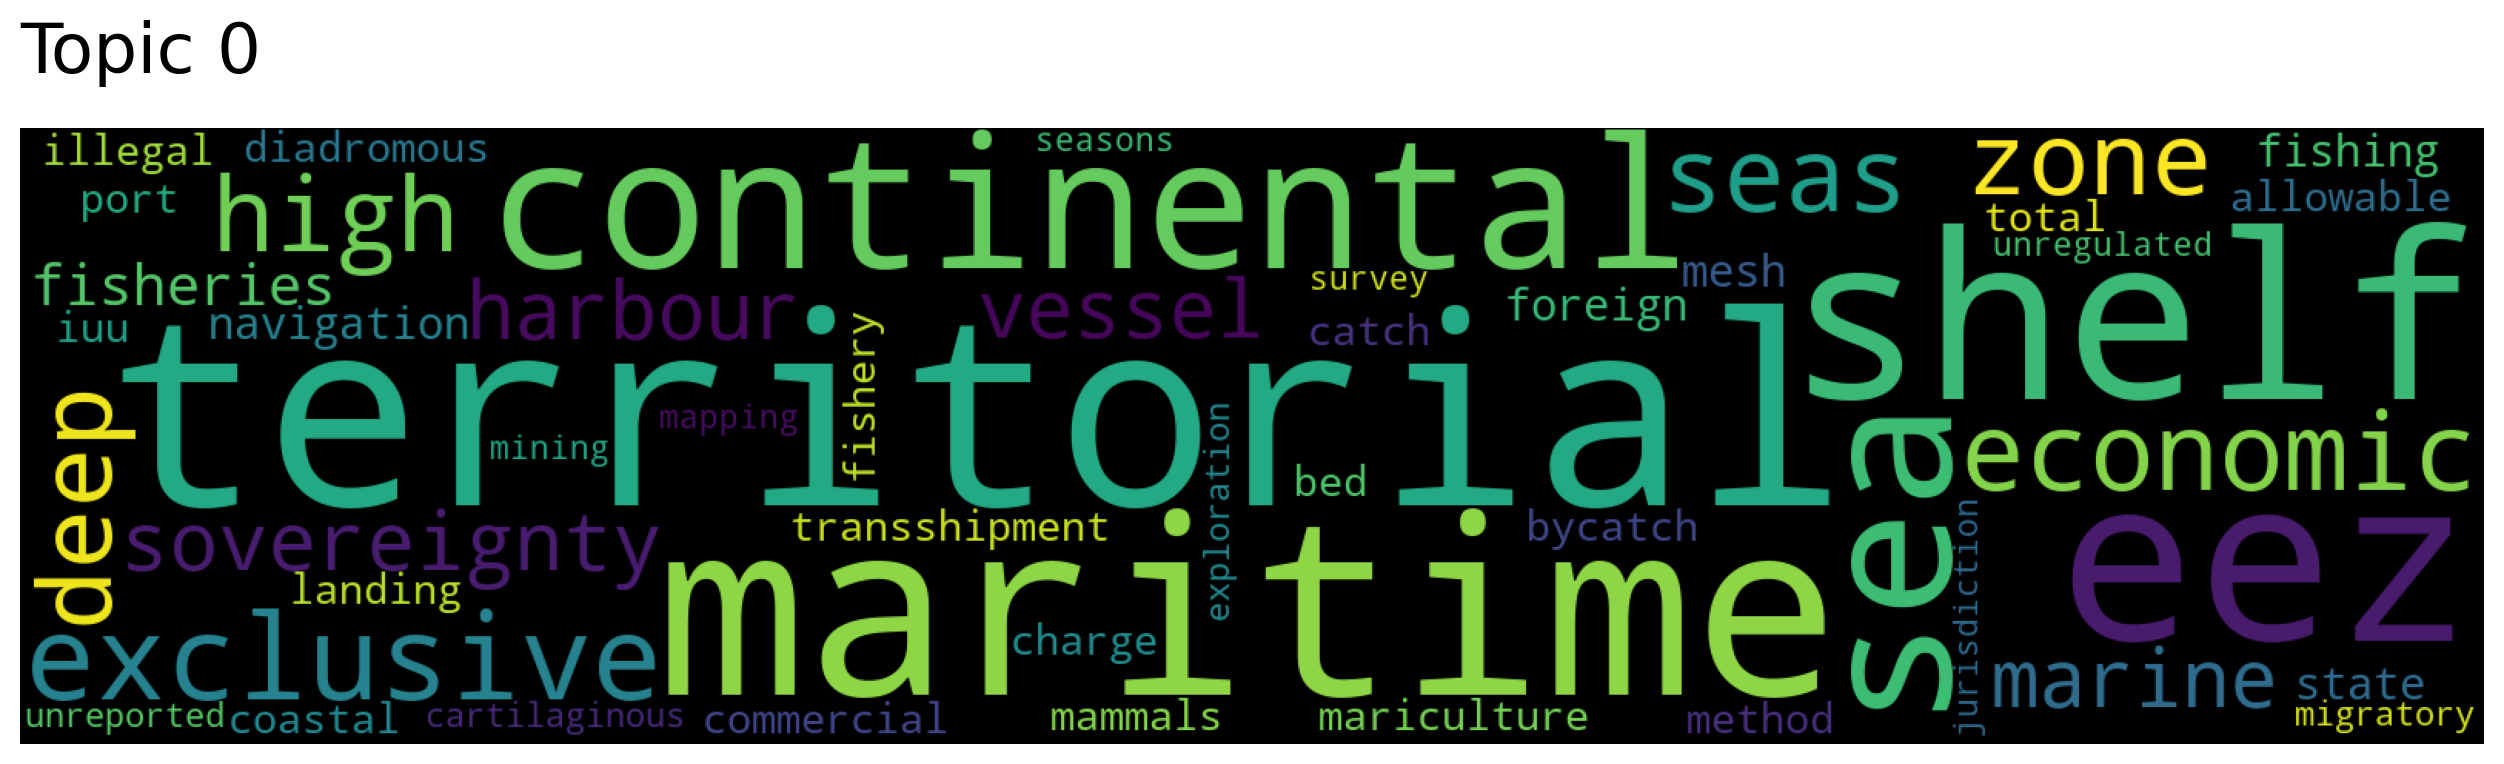

In [13]:
model.generate_topic_wordcloud(0)

In [100]:
# Look up topics corresponding to a keyword
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["waste"], num_topics=10)
print(topic_words)
print(topic_nums)
print(topic_scores)

[array(['sources', 'pays', 'polluter', 'domestic', 'waste', 'solid',
       'prevention', 'recycling', 'disposal', 'principle', 'reuse',
       'hazardous', 'movement', 'air', 'substances', 'pollution',
       'control', 'audit', 'precautionary', 'discharge', 'environmental',
       'effluent', 'plastic', 'noise', 'circular', 'rehabilitation',
       'ozone', 'charges', 'emissions', 'impact', 'freshwater',
       'industrial', 'economy', 'sewerage', 'eia', 'layer',
       'transboundary', 'compensation', 'clean', 'groundwater', 'soil',
       'payments', 'water', 'bioenergy', 'trading', 'assessment', 'prior',
       'ecofriendly', 'healthy', 'loss'], dtype='<U15'), array(['domestic', 'sources', 'solid', 'waste', 'prevention', 'disposal',
       'recycling', 'rehabilitation', 'reuse', 'hazardous', 'effluent',
       'discharge', 'substances', 'soil', 'movement', 'control',
       'pollution', 'pays', 'polluter', 'audit', 'erosion',
       'environmental', 'sewerage', 'improvement', 'pla

## Country co-occurence

- For hver tekst, find tilhørende topic --> noter landet til denne topic

In [260]:
# Compute uniqe countries --> i.e. remove agreement "countries" 
country_new=[]
for coun in country:
    if len(coun.split(";"))>=2:
        for c in coun.split("; "):
            country_new.append(c)
    else:
        country_new.append(coun)

In [582]:
#View all countries
#set(country_new)

In [261]:
# Make country dict --> key: country, value: country index
countries = {}
i=0
for country_x in (list(set(country_new))):
    countries[country_x]=i
    i+=1


In [262]:
# Compute country x topic occurence matrix
topic_sizes, topic_nums = model.get_topic_sizes()
country_topic_matrix = np.zeros((len(set(country_new)),len(topic_nums)))

for num in topic_nums:
    # For each topic get the corresponding documents
    documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=num,num_docs=topic_sizes[num])
    for id in document_ids:
        # Find the documents' countries and add it to the co-occurence matrix
        if len(country[id].split(";"))>=2:
            for c in country[id].split("; "):
                 country_topic_matrix[countries[c],num] +=1
        else:
            country_topic_matrix[countries[country[id]],num] +=1



In [263]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1,num_docs=topic_sizes[1])
document_scores

array([0.9672849 , 0.9637603 , 0.9633581 , ..., 0.69875014, 0.69690657,
       0.6083339 ], dtype=float32)

In [264]:

 
def get_swap_dict(d):
    return {v: k for k, v in d.items()}

countries_swap = get_swap_dict(countries)

#Standardisering
#for i in range(len(countries)):
 #   country_topic_matrix[i,:]=country_topic_matrix[i,:]/country_new.count(countries_swap[i]) 


In [267]:
def square_rooted(x):
        return np.sqrt(sum([a*a for a in x]))
def co_occurence(country_new,similarity):
    country_co_occurrence = np.zeros((len(set(country_new)),len(set(country_new))))

    for i in range(len(set(country_new))):
        for j in range(len(set(country_new))):
            if similarity == "correlation":
                # Correlation
                country_co_occurrence[i,j] = np.corrcoef(country_topic_matrix[i,:],country_topic_matrix[j,:])[0,1]
            elif similarity == "cosine":
                #Cosine similarity:
                country_co_occurrence[i,j] = country_topic_matrix[i,:]@country_topic_matrix[j,:]/(square_rooted(country_topic_matrix[i,:])*square_rooted(country_topic_matrix[j,:]))
            elif similarity == "euclidean":
                # Eucledean distance
                country_co_occurrence[i,j] = 1/(1+np.linalg.norm(country_topic_matrix[i,:]-country_topic_matrix[j,:]))
    return country_co_occurrence

country_co_occurrence = co_occurence(country_new,"correlation")
np.shape(country_co_occurrence)

(257, 257)

In [268]:
#Remove small islands

for i in range(len(set(country_new))):
    if country_new.count(countries_swap[i])<=20:
        country_co_occurrence[i] =0
        country_co_occurrence[:,i]=0

# Country Network

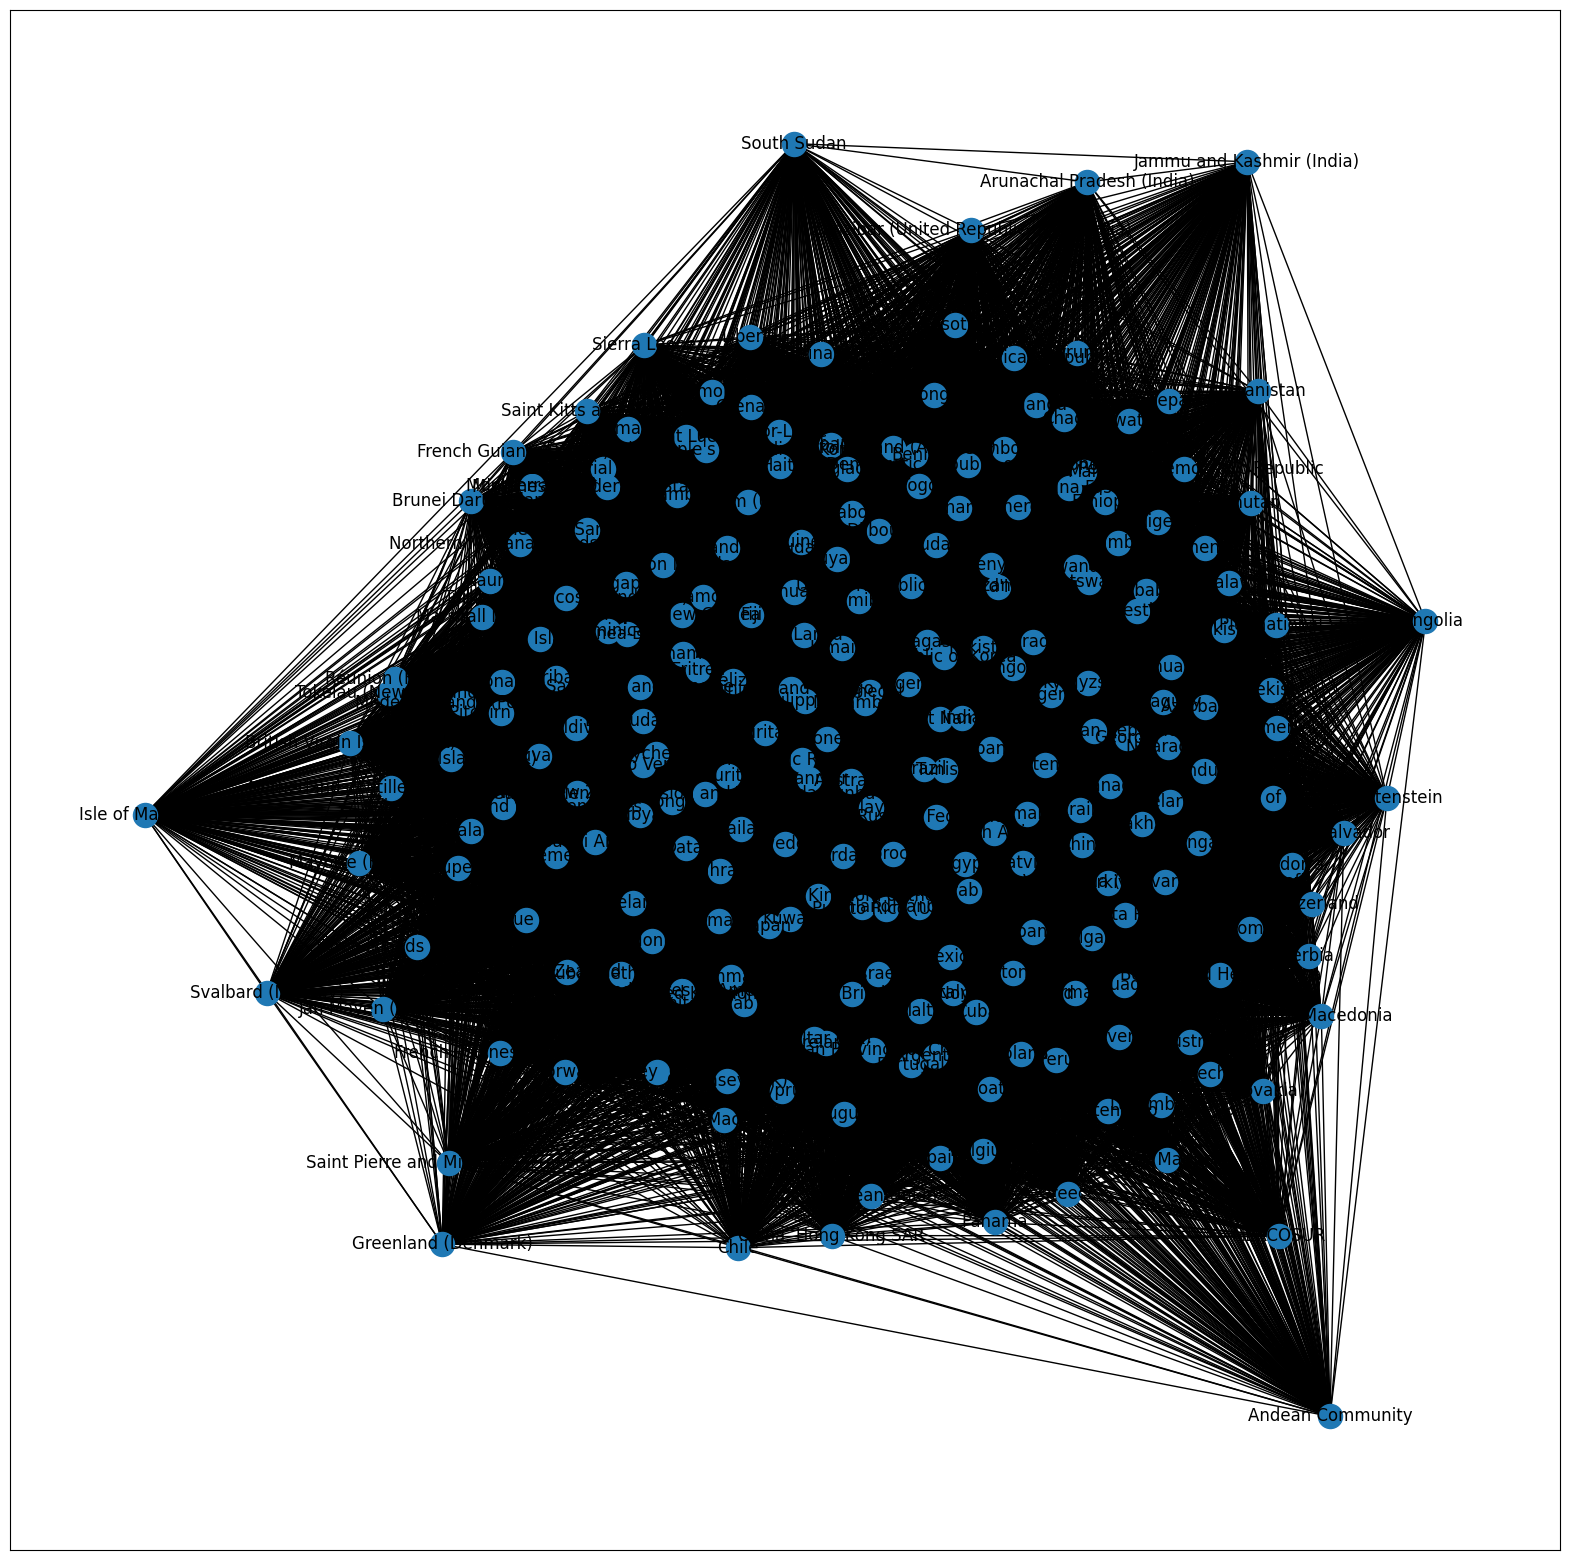

In [269]:
from networkx.algorithms.community import girvan_newman
import networkx as nx
import itertools
import matplotlib.pyplot as plt
countries_swap_copy = countries_swap.copy()

G = nx.Graph()

size = country_co_occurrence.shape[0]


G.add_nodes_from(range(size))

for i in range(size):
        for j in range(i+1, size):
            if country_co_occurrence[i, j] != 0.0:
            #if country_co_ocurrence[i, j] > 0.002:
                G.add_edge(i, j, weight=country_co_occurrence[i, j])
# Remove small isalnds
for i in range(size):
    if np.sum(country_co_occurrence[i])==0:
        G.remove_node(i)
        countries_swap_copy.pop(i)

plt.figure(figsize=(20, 20))
nx.draw_networkx(G, labels=countries_swap_copy,with_labels=True)
#nx.draw_spring(G, labels=countries_swap,with_labels=True)

In [378]:
from networkx.algorithms.community import louvain_communities
comms = louvain_communities(G,weight="weight",resolution=1.7,seed=69)
unique_coms = np.unique(list(comms))

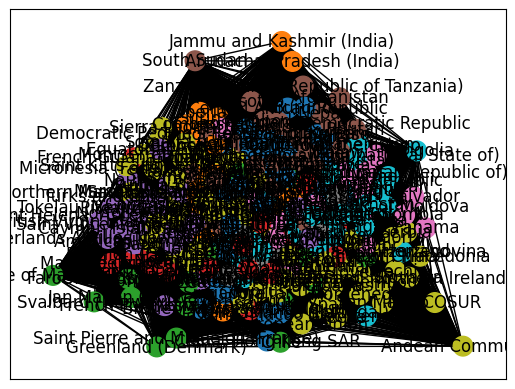

In [379]:
community_assignment = {}

# Assign community indices to nodes
for i, community in enumerate(comms):
    for node in community:
        community_assignment[node] = i

# Create a list of colors for each node based on the community assignment
node_colors = [community_assignment.get(node, -1) for node in G.nodes()]

# Draw the graph with different colors for different communities
pos = nx.spring_layout(G)  # Positions of nodes in the graph layout
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.tab10, node_size=200)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos,labels=countries_swap_copy)
plt.show()


In [380]:
i=1
communities={}
for community in comms:
    print("c",i)
    com_countries = []
    for c in community:
        print(countries_swap[c])
        com_countries.append(c)
    communities[i] = com_countries
    i=i+1

c 1
Chad
Cameroon
Côte d'Ivoire
Benin
Burundi
Democratic Republic of the Congo
Mauritania
Gabon
Madagascar
Niger
Mali
Togo
Algeria
Congo
Guinea
Djibouti
Central African Republic
Madeira Islands (Portugal)
Burkina Faso
Senegal
c 2
Singapore
Brunei Darussalam
China, Macao SAR
China, Hong Kong SAR
Bahrain
c 3
Thailand
Sri Lanka
c 4
United States of America
Philippines
c 5
Papua New Guinea
Comoros
Suriname
Democratic People's Republic of Korea
Solomon Islands
Liberia
Vanuatu
c 6
Tonga
Saint Helena, Ascension and Tristan da Cunha (UK)
c 7
Monaco
Viet Nam
c 8
Pakistan
India
Haiti
Jammu and Kashmir (India)
Arunachal Pradesh (India)
c 9
Namibia
c 10
Faroe Islands (Denmark)
Svalbard (Norway)
Argentina
Mexico
Jan Mayen (Norway)
Uruguay
Chile
Iceland
Saint Pierre and Miquelon (France)
Peru
Isle of Man (UK)
Norway
Greenland (Denmark)
New Zealand
c 11
Iraq
c 12
Australia
c 13
Syrian Arab Republic
Israel
Jersey  (UK)
c 14
Puerto Rico (USA)
Mayotte (France)
Martinique (France)
Réunion (France)
Guadel

In [646]:
# compute similartiy between countries:
#WIP
c1 = ["Pakistan","India"]
print(country_topic_matrix[countries["Pakistan"],:])
print(country_topic_matrix[countries["India"],:])
print(country_co_occurrence[countries["Pakistan"],countries["India"]])
for i in range(250):
    if country_co_occurrence[countries["Pakistan"],i] >=0.3:
        print(i,country_co_occurrence[countries["Pakistan"],i])

[1. 7. 0. ... 0. 0. 0.]
[ 1. 14.  1. ...  0.  0.  0.]
0.34177380012027875
13 0.3107047176504896
62 0.3030246210458938
71 0.34177380012027875
75 1.0
111 0.32447533365591413
131 0.3255293118102358
156 0.3112958517809433
166 0.35946196503805405
183 0.31037017670037603
220 0.3093927881565645
224 0.3262991676190901
249 0.34217898486727466


In [647]:
countries_swap[249]

'Senegal'

# Forskellige topic reduction

In [35]:
topic_mapping = model.hierarchical_topic_reduction(num_topics=200)

KeyboardInterrupt: 

In [197]:
print(model.topic_words_reduced)

[['steroids' 'hormones' 'mrl' 'residue' 'drugs' 'limit' 'hygiene'
  'maximum' 'swine' 'procedures' 'residues' 'sanitary' 'feed'
  'feedstuffs' 'veterinary' 'animal' 'toxicity' 'poultry' 'poisoning'
  'equine' 'slaughtering' 'meat' 'cattle' 'sheep' 'vaccination' 'goats'
  'additives' 'health' 'dairy' 'mercosur' 'safety' 'disinfestation'
  'codex' 'inspection' 'rodents' 'treated' 'haccp' 'disinfection'
  'andean' 'edible' 'packaging' 'pests' 'traceability' 'trade'
  'antimicrobial' 'diseases' 'welfare' 'labelling' 'milk' 'alimentarius']
 ['equine' 'sheep' 'swine' 'goats' 'cattle' 'rodents' 'herd' 'camelids'
  'book' 'reproduction' 'poultry' 'animal' 'slaughtering' 'vaccination'
  'mercosur' 'animals' 'welfare' 'meat' 'health' 'disinfestation' 'birds'
  'jersey' 'hygiene' 'sericulture' 'apiculture' 'steroids' 'hormones'
  'drugs' 'procedures' 'disinfection' 'quarantine' 'identification'
  'north' 'pests' 'feed' 'sanitary' 'ranching' 'inspection' 'marking'
  'captive' 'diseases' 'edible' '

In [202]:
model.topic_words_reduced[4]

array(['viticulture', 'oenological', 'tribunal', 'court', 'herzegovina',
       'beverages', 'tobacco', 'geographical', 'bosnia', 'indication',
       'fraud', 'settlement', 'codex', 'inspection', 'lao',
       'compensation', 'dispute', 'intellectual', 'labelling', 'trade',
       'certification', 'justice', 'practices', 'consumer', 'lanka',
       'liability', 'packaging', 'deceit', 'information', 'plant',
       'haccp', 'traceability', 'alimentarius', 'offences', 'internal',
       'tristan', 'adulteration', 'classification', 'singapore',
       'breeders', 'access', 'seeds', 'commodities', 'vested', 'sugar',
       'floriculture', 'veterinary', 'liechtenstein', 'legal',
       'agricultural'], dtype='<U14')

In [82]:
topic_words,word_scores,topic_nums = model.get_topics(10)
topic_words

array([['mesh', 'fishing', 'seasons', 'size', 'fishery', 'method',
        'cartilaginous', 'catch', 'bycatch', 'fisheries', 'landing',
        'prohibited', 'marine', 'total', 'allowable', 'charge',
        'allocation', 'fishes', 'vessel', 'gear', 'quota', 'artisanal',
        'foreign', 'commercial', 'diadromous', 'port', 'migratory',
        'transshipment', 'turtles', 'mammals', 'molluscs', 'crustaceans',
        'illegal', 'high', 'seas', 'inland', 'iuu', 'territorial',
        'unregulated', 'area', 'exclusive', 'state', 'eez',
        'enhancement', 'management', 'conservation', 'coral',
        'unreported', 'repopulation', 'sea'],
       ['floriculture', 'planting', 'seeds', 'material', 'fibre',
        'plant', 'cane', 'beet', 'variety', 'vegetables', 'breeders',
        'oleaginous', 'legumes', 'fruits', 'edible', 'nuts', 'sugar',
        'certification', 'rice', 'tobacco', 'cereals', 'labelling',
        'weeds', 'crops', 'oenological', 'production', 'packaging',
        '

In [273]:
import pandas as pd
#country data
income = pd.read_excel("CLASS.xlsx")
print(income.keys())

Index(['Economy', 'Code', 'Region', 'Income group', 'Lending category',
       'Other (EMU or HIPC)'],
      dtype='object')


In [316]:

income_countries = list(income["Economy"])
income_groups = list(income["Income group"])
income_listed_countries =[]
countries_income_dic ={}
for i in range(len(income_countries)):
    for j in range(len(countries_swap)):
        if income_countries[i] == countries_swap[j]:
            income_listed_countries.append(j)
            if income_groups[i] == "Low income":
                countries_income_dic[j]= 0
            elif income_groups[i] == "Lower middle income":
                countries_income_dic[j]= 1
            elif income_groups[i] == "Upper middle income":
                countries_income_dic[j]= 2
            elif income_groups[i] == "High income":
                countries_income_dic[j]= 3
missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in income_listed_countries:
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])


In [317]:
from fuzzywuzzy import process
matches = []
threshold = 90  # Adjust the threshold as per your needs

for country1 in missing_income_countries_names:
    best_match = process.extractOne(country1, income_countries)
    if best_match[1] >= threshold:
        matches.append((country1, best_match[0]))


# Print the matches
for match in matches:
    print("Match:", match[0], "-", match[1])

print(len(matches))
print("matches found")

Match: Faroe Islands (Denmark) - Denmark
Match: Netherlands Antilles (Netherlands) - Netherlands
Match: Jan Mayen (Norway) - Norway
Match: China, Macao SAR - Macao SAR, China
Match: Juan de Nova Island (France) - France
Match: Sint Maarten (Netherlands) - Netherlands
Match: Saint Pierre and Miquelon (France) - France
Match: Niue (New Zealand) - New Zealand
Match: United States of America - United States
Match: Isle of Man (UK) - Isle of Man
Match: Aruba (Netherlands) - Aruba
Match: China, Hong Kong SAR - Hong Kong SAR, China
Match: Saint Martin (France) - France
Match: Egypt - Egypt, Arab Rep.
Match: Réunion (France) - France
Match: Bahamas - Bahamas, The
Match: New Caledonia (France) - France
Match: Tromelin Island (France) - France
Match: Mayotte (France) - France
Match: Turks and Caicos Islands (UK) - Turks and Caicos Islands
Match: French Guiana (France) - France
Match: Sao Tome and Principe - São Tomé and Príncipe
Match: Côte d'Ivoire - Côte d’Ivoire
Match: Kosovo (UNSCR 1244) - K

In [369]:

#manual_income =  [(0,3),(1,3),(5,3),(8,3),(12,3),(13,3),()]
for i,j in matches:
    if income_groups[income_countries.index(j)] == "Low income":
        countries_income_dic[countries[i]]= 0
    elif income_groups[income_countries.index(j)] == "Lower middle income":
        countries_income_dic[countries[i]]= 1
    elif income_groups[income_countries.index(j)] == "Upper middle income":
        countries_income_dic[countries[i]]= 2
    elif income_groups[income_countries.index(j)] == "High income":
        countries_income_dic[countries[i]]= 3


missing_income_countries = []
missing_income_countries_names=[]
for i in countries_swap.keys():
    if i not in countries_income_dic.keys():
        missing_income_countries.append(i)
        missing_income_countries_names.append(countries_swap[i])

In [370]:
extra_countries = [('Saint Barthélemy (FRA)',3),('Kyrgyzstan',1),('Andean Community',2),('Palestine',1),('Iran (Islamic Republic of)',1),('Slovakia',3),('Saint Helena, Ascension and Tristan da Cunha (UK)',3),('Jersey  (UK)',3),('Montserrat (UK)',3),('European Union',3),("Democratic People's Republic of Korea",0),('Falkland Islands (Malvinas)',3),
('Anguilla (UK)',3),('Cook Islands',3),('Micronesia (Federated States of)',1),('Republic of Korea',3),('MERCOSUR',2),('Democratic Republic of the Congo',0),('Guernsey (UK)',3),('Saint Lucia',2),('Czechia',3),('Venezuela (Bolivarian Republic of)',1),('Pitcairn (UK)',3),("Lao People's Democratic Republic",1)]

for i,j in extra_countries:
    countries_income_dic[countries[i]]= j


In [371]:
# Compare countries income: function takes a list of country indexes and returns the rang between lowest and higest income country and the standard deviation
def check_income(community):
    com_income = []
    for i in community:
        com_income.append(countries_income_dic[i])
    range = max(com_income)-min(com_income)
    std = np.std(com_income)
    return range, std
    

    

In [372]:
c1 = [countries["Denmark"],countries["Sweden"]]
for i in range(len(communities)):
    print(check_income(communities[i+1]))

(0, 0.0)
(2, 0.605625302411)
(0, 0.0)
(2, 1.0)
(0, 0.0)
(1, 0.4714045207910317)
(2, 0.7483314773547883)
(2, 0.5668594533825794)
(0, 0.0)
(2, 0.7071067811865476)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(2, 0.7180219742846006)
(0, 0.0)
(1, 0.410325903324145)
(0, 0.0)
(0, 0.0)
(3, 1.4142135623730951)
(2, 0.7118052168020874)
(0, 0.0)
(0, 0.0)
(1, 0.4714045207910317)
(0, 0.0)
(1, 0.4714045207910317)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(1, 0.4714045207910317)
(3, 1.0908712114635715)
(1, 0.4714045207910317)
(1, 0.4330127018922193)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(1, 0.5)
(0, 0.0)
(0, 0.0)
(2, 0.6236095644623235)
(1, 0.4714045207910317)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(3, 1.1661903789690602)
(1, 0.42791978089623645)
(0, 0.0)
(0, 0.0)
(0, 0.0)
(0, 0.0)


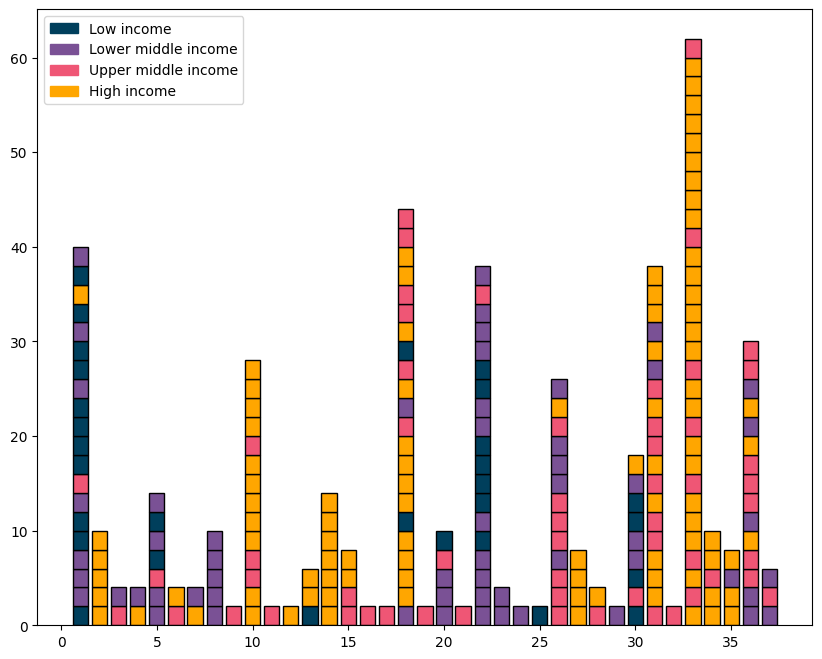

In [381]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'n','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w','b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
plt.figure(figsize=(10, 8))
for j in range(len(communities)):
    for i in range(len(communities[j+1])):
        if i == 0:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, color="#ffa600",width=0.8,edgecolor="#000000")
            h=2
        else:
            if countries_income_dic[communities[j+1][i]] == 0:
                plt.bar(j+1, 2, bottom=h, color="#003f5c",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 1:
                plt.bar(j+1, 2, bottom=h, color="#7a5195",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 2:
                plt.bar(j+1, 2, bottom=h, color="#ef5675",width=0.8,edgecolor="#000000")
            elif countries_income_dic[communities[j+1][i]] == 3:
                plt.bar(j+1, 2, bottom=h, color="#ffa600",width=0.8,edgecolor="#000000")
            h=h+2
pop_a = mpatches.Patch(color='#003f5c', label="Low income")
pop_b = mpatches.Patch(color='#7a5195', label="Lower middle income")
pop_c = mpatches.Patch(color='#ef5675', label="Upper middle income")
pop_d = mpatches.Patch(color='#ffa600', label='High income')
plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])



In [417]:
for c in communities[37]:
    print(countries_swap[c])

Egypt
Türkiye
Lebanon


In [388]:
print("Low: ",income_groups.count("Low income"),income_groups.count("Low income")/len(income_groups))
print("Lower middle: ",income_groups.count("Lower middle income"),income_groups.count("Lower middle income")/len(income_groups))
print("Upper middle: ",income_groups.count("Upper middle income"),income_groups.count("Upper middle income")/len(income_groups))
print("High: ",income_groups.count("High income"),income_groups.count("High income")/len(income_groups))

Low:  28 0.10566037735849057
Lower middle:  54 0.2037735849056604
Upper middle:  54 0.2037735849056604
High:  81 0.30566037735849055


# Data analyse

In [78]:
print(keywords[15])
print(len(keywords[15]))

marine fisheries traditional rights/customary rights fishing authorization allocation/quota fishery management and conservation
127


In [66]:
# Tæl hvor mange der er repealed inden for et dato interval
dates=data["Date of original text"]
repealed=data["Repealed"]
antal=0
for i in range(1800,2022):
    c=dates==str(i)
    d=repealed=="Y"
    antal+=sum(c*d)
print(antal)


965


In [ ]:
#Append country to keywords -- outdated
#i=0

#for words in keywords:
 #   keywords[i]=words + [" "+country[i]]
  #  i+=1

In [ ]:
# Find number of extinct domains
a= list(set(data["Domain"]))
i=0
for words in a:
    if type(words)!=str:
        #print("type= ",type(words)," Index = ", i)
        words="Nan"
    a[i]=words.split(";")

    i+=1

In [ ]:
# print different domains
a=sum(a,[])
i=0
for word in a:
        word=word.strip()
        a[i]=word
        i+=1

print(set(a))



In [ ]:
# Count number documents in a language
languages=list(data["Language of document"])
print(languages.count("English"))

In [125]:
set(country)

{'Cameroon; Senegal',
 'Armenia; Azerbaijan; Belarus; Kazakhstan; Kyrgyzstan; Republic of Moldova; Russian Federation; Tajikistan; Turkmenistan; Uzbekistan; Ukraine',
 'European Union; Sao Tome and Principe',
 'Switzerland; Uzbekistan',
 'Russian Federation; Jordan',
 'Russian Federation; Saudi Arabia',
 'Portugal; Mozambique; Eswatini',
 'France; India',
 'Central African Republic',
 'Germany; Latvia',
 'Angola; Botswana; Democratic Republic of the Congo; Lesotho; Malawi; Mauritius; Mozambique; Namibia; Seychelles; South Africa; Eswatini; United Republic of Tanzania; Zambia; Zimbabwe',
 'Uruguay; Brazil',
 'Philippines; Indonesia',
 'Clipperton Island (France)',
 "Benin; Burkina Faso; Cameroon; Chad; Côte d'Ivoire; Guinea; Mali; Niger; Nigeria",
 'United States of America; American Samoa (USA)',
 'Senegal; United States of America',
 'Qatar',
 'China; Australia',
 'Papua New Guinea; Solomon Islands',
 'Cabo Verde; Japan',
 'Northern Mariana Islands (USA)',
 'United Kingdom of Great Br

- Cluster topics
- Dendogram